# Non-linear fits as extensions of line fits

Line fits are really useful and they can be easily modified to perform non-linear fits too.

One way of modifying them is to simply "create" new variables. For example, if one would like to fit a parabola $y = f(x) = a x^2 + b x + c$, one could define a new variable $u = x^2$ and fit the "plane" $y = f(x, u) = a u + b x + c$. This fit may be performed with the methods described previously. There are even tools in standard libraries to aid fitting using such procedures.

An alternative is to perform a non-linear transformation on $x$, in such a way that the important non-linear effects are captured.


In [1]:
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## Fitting polynomials

scikit-learn offers the possibility of easily creating new variables corresponding to the polynomial expansions of $x$.
This can be done using: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures

Let's look at an example of how this could be done:

The simulated example data will be $f(x) = 0.01 x^2 + 0.5 x + 0.3 + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu=0, \sigma=0.5)$.


In [2]:
def generate_data(N: int) -> np.ndarray:
    x = 2*np.random.randn(N, 1)
    epsilon = 0.5*np.random.randn(N, 1)
    z = 0.1*x**2 + 0.5*x + 0.3 + epsilon
    return np.concatenate((x, z), axis=1).astype(np.float32)

data = generate_data(N=100)

Let's plot it:

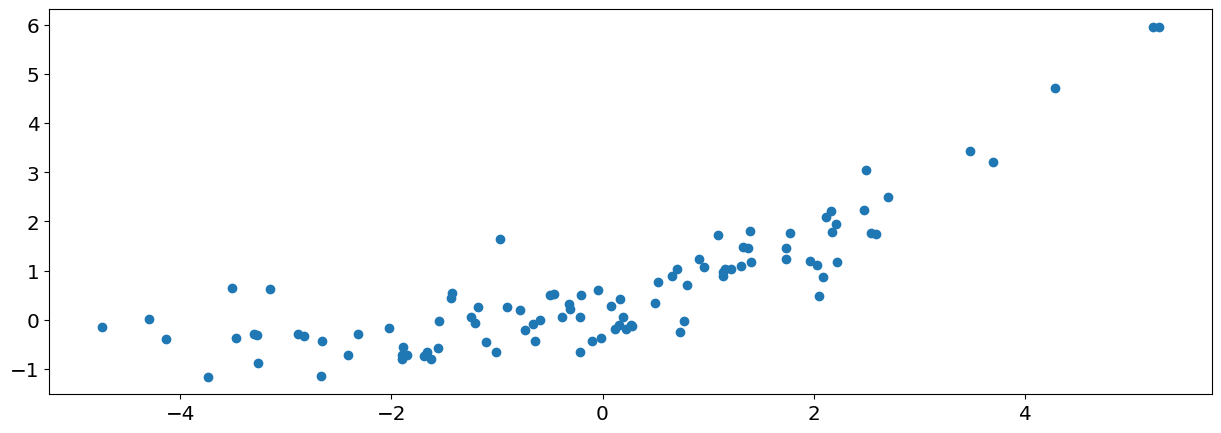

In [3]:
plt.scatter(data[:,0], data[:,1])

Now, let's fit it with a line:

In [4]:
from sklearn.linear_model import BayesianRidge

model = BayesianRidge()
model.fit(data[:, [0]], data[:, 1])


BayesianRidge()

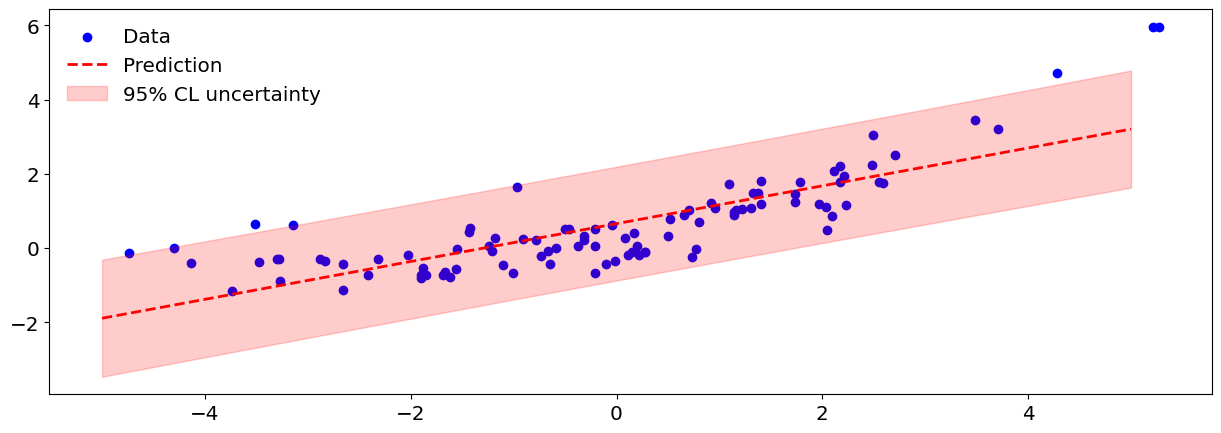

In [5]:
x_axis = np.linspace(-5, 5, 100)
y_p, y_u = model.predict(x_axis[:, np.newaxis], return_std=True)

plt.scatter(data[:, 0], data[:, 1], c='b', label="Data")
plt.plot(x_axis, y_p, c='r', lw=2, ls='--', label="Prediction")
plt.fill_between(x_axis, y_p-2*y_u, y_p+2*y_u, color='red', alpha=0.2, label="95% CL uncertainty")
plt.legend(frameon=False)

This has a large uncertainty and it really does not capture the quadratic effect! Let's try to fit it adding one extra variable $u=x^2$. We could just calculate this variable and add it to the dataset, but when working with many dimensions and with higher powers (not only second-order polynomials), it is easier to use the auxiliary object `PolynomialFeatures`.

In [6]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures

feature_extractor = PolynomialFeatures(2)
data_preprocessed = feature_extractor.fit_transform(data[:, [0]])

model = BayesianRidge()
model.fit(data_preprocessed, data[:, 1])

BayesianRidge()

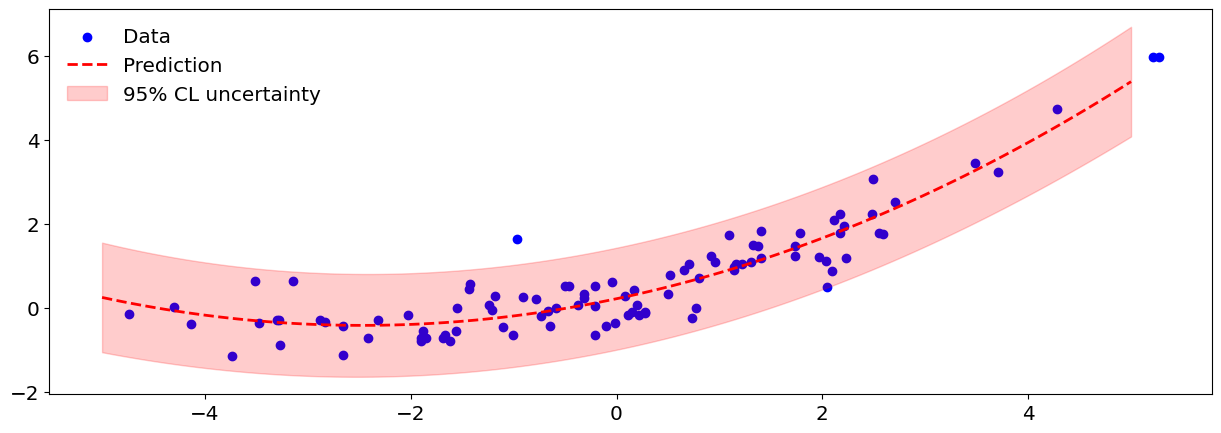

In [7]:
preprocessed_x_axis = feature_extractor.fit_transform(x_axis[:, np.newaxis])
y_p, y_u = model.predict(preprocessed_x_axis, return_std=True)

plt.scatter(data[:, 0], data[:, 1], c='b', label="Data")
plt.plot(x_axis, y_p, c='r', lw=2, ls='--', label="Prediction")
plt.fill_between(x_axis, y_p-2*y_u, y_p+2*y_u, color='red', alpha=0.2, label="95% CL uncertainty")
plt.legend(frameon=False)

This looks much better! We can also do this in a more streamlined way using the concept of `Pipeline` in scikit-learn, which does this transformation for us in a more transparent way.

In [8]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

model = Pipeline([('feature_extractor', PolynomialFeatures(2)),
                  ('fit', BayesianRidge())
                 ])
model.fit(data[:,[0]], data[:,1])


Pipeline(steps=[('feature_extractor', PolynomialFeatures()),
                ('fit', BayesianRidge())])

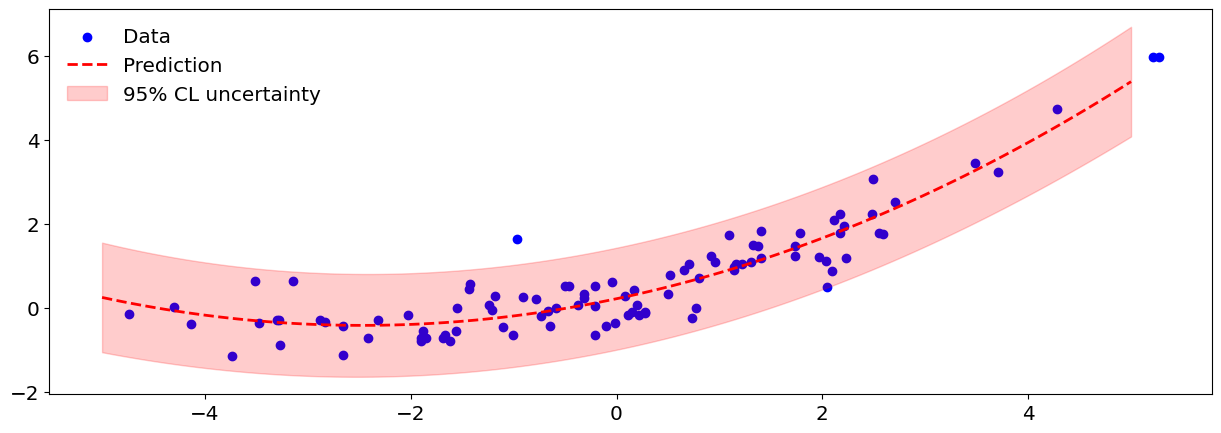

In [9]:
y_p, y_u = model.predict(x_axis[:, np.newaxis], return_std=True)

plt.scatter(data[:, 0], data[:, 1], c='b', label="Data")
plt.plot(x_axis, y_p, c='r', lw=2, ls='--', label="Prediction")
plt.fill_between(x_axis, y_p-2*y_u, y_p+2*y_u, color='red', alpha=0.2, label="95% CL uncertainty")
plt.legend(frameon=False)

## Kernel methods

Another simple extension of linear fits is to apply a non-linear transformation on the input $x$ values indirectly. The logic here is the following: when looking at the derivation of the equations for linear fit results, we see that the results don't really depend on the $x$ values of each point directly. They only depend on the dot-product between $x$ values between different points, that is, on $\vec{x}_1 \cdot \vec{x}_2 = \sum_i x_{1i} x_{2i}$. If we substituted the *definition of dot product* in our space with something else, we are effectively changing how we measure distances in the space of points. This change in the curvature of the space may detect non-linear relationships more easily.

When using this method we are effectively performing the fit:

$y = f(x) = \sum_i w_i \phi_i(x_i) + w_0$

The only change here is that the only thing that enters the method are the pre-transformed versions of the input $x_i$ components.
We never really have to calculate $\phi_i$, since the only thing that enters our linear fit equations for $\phi_i(x_i)$ is actually $\phi_i(x)_i \phi_j(x_j)$ for all combinations of $i$ and $j$. We define this quantity kernel $K(x, x^\prime) = \phi(x) \cdot \phi(x^\prime)$ and it is conceptualized as a measure of relationship between the different $x$ values.

Let's look at an example of this using the kernel function $K(x, x^\prime) = (\gamma x \cdot x^\prime + 1)^3$. This is called the *polynomial* kernel, but you can define your own kernel.

In [10]:
from sklearn.kernel_ridge import KernelRidge

model = KernelRidge(kernel="polynomial")
model.fit(data[:,[0]], data[:,1])


KernelRidge(kernel='polynomial')

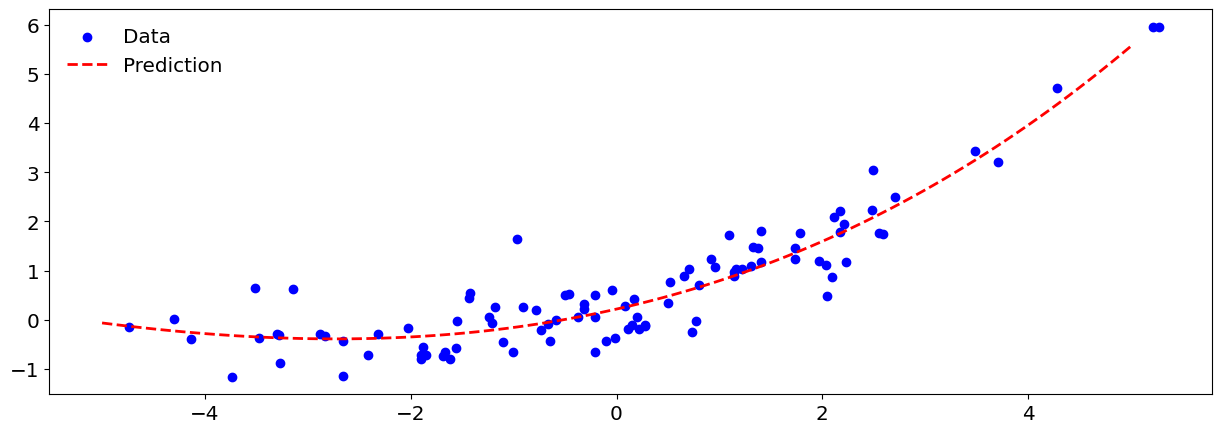

In [11]:
y_p = model.predict(x_axis[:, np.newaxis])

plt.scatter(data[:, 0], data[:, 1], c='b', label="Data")
plt.plot(x_axis, y_p, c='r', lw=2, ls='--', label="Prediction")
plt.legend(frameon=False)

This particular model implementation does not define uncertainties in the result (more on that later), but notice that the non-linearity is correctly captured by such a method.

A different way of looking at this is that the kernel encodes a transformation to a space of functions that could fit this data. That is, there are infinite functions that fit the data, but the choice of the kernel selects some of them.

The disadvantage here is that the parabolic nature of the original function is not so obvious, but the entire structure of the non-linearity is shifted to the choice of the kernel function. Choosing a different kernel leads to a very different result.

The underlying code used here is actually very similar to the linear fit done previously: the key difference is that the *design* matrix is changed to depend on $K$ instead of the $x$ values directly. What we are doing here is still, behind the scenes, a linear fit!

This method is called often the *kernel trick*, since it allows very complex fits with a small change in the fit procedure.